# Automated Essay Scoring 

### What is this Notebook about?

- This Notebook contains all raw results and experiments done with the various deep learning methods. The output cells contains the results that we got. The whole Notebook may take approximately 5-6 hours. This Notebook contains the following:

* Preprocess data
* Important util methods to be used later
* Deep Learning Model declaration
* Running bert for individual sets
* Running bert for whole dataset
* Running word2vec for individual sets
* Running word2vec for whole dataset

# Install and import packages

In [1]:
import tensorflow as tf
import sys
print(tf.__version__)
print(tf.config.list_physical_devices())
print('Hi mom')

2.8.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Hi mom


In [2]:
# !{sys.executable} -m pip install sacremoses

In [3]:
import transformers as ppb

In [4]:
# import important libraries and download data
import os
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import cohen_kappa_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import multiprocessing
%matplotlib notebook
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
import collections
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')  
# ! git clone https://github.com/Gaurav-Pande/AES_DL.git && mv AES_DL/data .

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/SonTungKieu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/SonTungKieu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/SonTungKieu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Preprocess

In [5]:
# Declaring some visualization methods to plot accuracy and model diagram
def plot_accuracy_curve(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['mse'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

def plot_acrchitecture(filename, model):
    plot_model(model, to_file=str(filename) + '.png')

In [6]:
# method to split data into sets
def split_in_sets(data):
    essay_sets = []
    min_scores = []
    max_scores = []
    
    for s in range(1,9):
        essay_set = data[data["essay_set"] == s]
        essay_set.dropna(axis=1, inplace=True)
        n, d = essay_set.shape
        set_scores = essay_set["domain1_score"]
        print ("Set", s, ": Essays = ", n , "\t Attributes = ", d)
        min_scores.append(set_scores.min())
        max_scores.append(set_scores.max())
        essay_sets.append(essay_set)
    
    return (essay_sets, min_scores, max_scores)

In the below cell, we can see the data we need to operate. We essentially drops the column, we dont need and keep the domain_score only along with essay text.

In [7]:
dataset_path = "./data/training_set_rel3.tsv"
data = pd.read_csv(dataset_path, sep="\t", encoding="ISO-8859-1")
min_scores = [2, 1, 0, 0, 0, 0, 0, 0]
max_scores = [12, 6, 3, 3, 4, 4, 30, 60]
essay_sets, data_min_scores, data_max_scores = split_in_sets(data)
set1, set2, set3, set4, set5, set6, set7, set8 = tuple(essay_sets)
data.dropna(axis=1, inplace=True)
data.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
set1.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
set2.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
set3.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
set4.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
set5.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
set6.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
set7.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
set8.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
sets = [set1,set2,set3,set4,set5,set6,set7,set8]
data.head()

/var/folders/pj/ldkmdmbj5bld43hhctfjwh280000gn/T/ipykernel_18021/2675578851.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  essay_set.dropna(axis=1, inplace=True)
/var/folders/pj/ldkmdmbj5bld43hhctfjwh280000gn/T/ipykernel_18021/810880094.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set1.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
/var/folders/pj/ldkmdmbj5bld43hhctfjwh280000gn/T/ipykernel_18021/810880094.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

Set 1 : Essays =  1783 	 Attributes =  6
Set 2 : Essays =  1800 	 Attributes =  9
Set 3 : Essays =  1726 	 Attributes =  6
Set 4 : Essays =  1770 	 Attributes =  6
Set 5 : Essays =  1805 	 Attributes =  6
Set 6 : Essays =  1800 	 Attributes =  6
Set 7 : Essays =  1569 	 Attributes =  14
Set 8 : Essays =  723 	 Attributes =  18


/var/folders/pj/ldkmdmbj5bld43hhctfjwh280000gn/T/ipykernel_18021/810880094.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set6.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
/var/folders/pj/ldkmdmbj5bld43hhctfjwh280000gn/T/ipykernel_18021/810880094.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  set7.drop(columns=["rater1_domain1", "rater2_domain1"], inplace=True)
/var/folders/pj/ldkmdmbj5bld43hhctfjwh280000gn/T/ipykernel_18021/810880094.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8


In [8]:
data.shape

(12976, 4)

 There are named entity tags as you can see above, which can impact our model. so we need to remove them from the dataframe. So we will extend our stopwords set later on. But first we need to create all possible ner tags.

In [9]:
cap = ['@CAPS'+str(i) for i in range(100)]
loc = ['@LOCATION'+str(i) for i in range(100)]
org =['@ORGANIZATION'+str(i) for i in range(100)]
per = ['@PERSON'+str(i) for i in range(100)]
date = ['@DATE'+str(i) for i in range(100)]
time = ['@TIME'+str(i) for i in range(100)]
money = ['@MONEY'+str(i) for i in range(100)]
ner =  cap + loc + org + per + date + time + money

## Normalize score

In [10]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(7, 7), sharey=False)

for i in range(4):
    for j in range(2):
        topic_number += 1
        data[data['essay_set'] == topic_number].groupby('domain1_score')['essay_id'].agg('count').plot.bar(ax=ax[i, j], rot=0, color="maroon")
        ax[i,j].set_title('Essay %i' % topic_number)
        
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<IPython.core.display.Javascript object>

In [11]:
data.head()

,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",8
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",9
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",7
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",10
4,5,1,"Dear @LOCATION1, I know having computers has a...",8


In [12]:
for topic in range(1, 9):
    sets = data[data['essay_set'] == topic]
    min_set = sets['domain1_score'].min()
    max_set = sets['domain1_score'].max()

    data.loc[data['essay_set'] == topic, 'domain1_score'] = data[data['essay_set'] == topic]['domain1_score'].apply(lambda x: (x - min_set) / (max_set - min_set))
    # data[data['essay_set'] == topic]['domain1_score'].apply(lambda x: (x - min_set) / (max_set - min_set))
    # data[data['essay_set'] == topic]['domain1_score']

data


,essay_id,essay_set,essay,domain1_score
0,1,1,"Dear local newspaper, I think effects computer...",0.60
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",0.70
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",0.50
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",0.80
4,5,1,"Dear @LOCATION1, I know having computers has a...",0.60
...,...,...,...,...
12971,21626,8,In most stories mothers and daughters are eit...,0.50
12972,21628,8,I never understood the meaning laughter is th...,0.44
12973,21629,8,"When you laugh, is @CAPS5 out of habit, or is ...",0.60
12974,21630,8,Trippin' on fen...,0.60


In [13]:
topic_number = 0
fig, ax = plt.subplots(4,2, figsize=(7, 7), sharey=False)

for i in range(4):
    for j in range(2):
        topic_number += 1
        data[data['essay_set'] == topic_number].groupby('domain1_score')['essay_id'].agg('count').plot.bar(ax=ax[i, j], rot=0, color="maroon")
        ax[i,j].set_title('Essay %i' % topic_number)
        
ax[3,0].locator_params(nbins=10)
ax[3,1].locator_params(nbins=10)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

<IPython.core.display.Javascript object>

In [14]:
data[data['essay_set'] == 7].domain1_score.max()

1.0

Some utility functions declarations needed to convert the raw essay to word list.

# Model

In [15]:
from keras.layers import Embedding, Input, LSTM, Dense, Dropout, Lambda, Flatten, Bidirectional, Conv2D, Conv1D, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization
from keras.models import Sequential, Model, load_model, model_from_config
import keras.backend as K
import time
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
from tensorflow.keras.callbacks import ModelCheckpoint

In [16]:
class BERTung:
    def __init__(self, data):
        self.data = data

    """Define the model."""
    def get_model(self, bidirectional_status:bool = True, Hidden_dim1: int =400, Hidden_dim2:int=128, return_sequence:bool=True, drop_out_value:float=0.5, recurrent_drop_out:float=0.4, inputsize:int=768, activation_func='relu'):
        '''
        bidirectional: False => LSTM,
                       True => Bidirectional LSTM
        '''

        model = Sequential()
        if bidirectional_status:
            model.add(Bidirectional(LSTM(Hidden_dim1, return_sequences=return_sequence , dropout=drop_out_value, recurrent_dropout=recurrent_drop_out), input_shape=[1, inputsize]))
            model.add(Bidirectional(LSTM(Hidden_dim2, recurrent_dropout=recurrent_drop_out)))
        else:
            model.add(LSTM(Hidden_dim1, dropout=drop_out_value, recurrent_dropout=recurrent_drop_out, input_shape=[1, inputsize], return_sequences=return_sequence))
            model.add(LSTM(Hidden_dim2, recurrent_dropout=recurrent_drop_out))

        model.add(Dropout(drop_out_value))
        model.add(Dense(1, activation=activation_func))
        model.add(BatchNormalization())

        model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae', 'mse'])
        return model

    def get_features(self, X, model):
        max_len = 0
        for i in X.values:
            if len(i) > max_len:
                max_len = len(i)

        padded_X = np.array([i + [0]*(max_len-len(i)) for i in X.values])
        attention_mask_X = np.where(padded_X != 0, 1, 0)
        X_input_ids = torch.tensor(padded_X)
        X_attention_mask = torch.tensor(attention_mask_X)

        with torch.no_grad():
            last_hidden_states_X = model(X_input_ids, attention_mask=X_attention_mask)

        X_features = last_hidden_states_X[0][:,0,:].numpy()

        return X_features

    # '''Train model'''
    def train_model(self, model_name, bidirectional=False):
        '''
        BERT: True => BERT
              False => DistilBERT
        '''

        global tokenizer_class
        cv = KFold(n_splits=5, shuffle=True)
        X = self.data
        y = self.data['domain1_score']
        cv_data = cv.split(X)

        results = []
        prediction_list = []
        fold_count = 1

        if model_name == 'BERT':
            model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
        elif model_name == 'DistilBERT':
            model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
        elif model_name == 'ALBERT':
            model_class, tokenizer_class, pretrained_weights = (ppb.AlbertModel, ppb.AlbertTokenizer, 'albert-large-v2')

        # Load pretrained model/tokenizer
        tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
        model = model_class.from_pretrained(pretrained_weights)

        for traincv, testcv in cv_data:
            print("\n--------Fold {}--------\n".format(fold_count))

            # get the train and test from the dataset.
            X_train, X_test, y_train, y_test = X.iloc[traincv], X.iloc[testcv], y.iloc[traincv], y.iloc[testcv]
            train_essays = X_train['essay']
            test_essays = X_test['essay']
        #     print(train_essays)

            sentences = []
            tokenize_sentences = []
            train_bert_embeddings = []

            tokenized_train = train_essays.apply((lambda x: tokenizer.encode(x, add_special_tokens=True ,max_length=55)))
            tokenized_test = test_essays.apply((lambda x: tokenizer.encode(x, add_special_tokens=True ,max_length=55)))


            train_features = self.get_features(tokenized_train, model)
            test_features = self.get_features(tokenized_test, model)

            print(train_features[:1])
            print(test_features[:1])
    #
    #         train_x, train_y = train_features.shape
    #         test_x,test_y = test_features.shape
    #         trainDataVectors = np.reshape(train_features, (train_x, 1, train_y))
    #         testDataVectors = np.reshape(test_features, (test_x, 1, test_y))
    #
    #         lstm_model = self.get_model(Hidden_dim1=Hidden_dim1, Hidden_dim2=Hidden_dim2, return_sequences=return_sequences,
    #                                 dropout=dropout, recurrent_dropout=recurrent_dropout, input_size=input_size,
    #                                 activation=activation, bidirectional=bidirectional)
    #         history = lstm_model.fit(trainDataVectors, y_train, batch_size=batch_size, epochs=epoch)
    #
    #         plot_accuracy_curve(history)
    #         y_pred = lstm_model.predict(testDataVectors)
    #         y_pred = np.around(y_pred)
    #         #y_pred.dropna()
    #         np.nan_to_num(y_pred)
    #
    #         # evaluate the model
    #         print(y_pred)
    #         result = cohen_kappa_score(y_test.values, y_pred, weights='quadratic')
    #         print("Kappa Score: {}".format(result))
    #         results.append(result)
    #         fold_count +=1
    #
    #         tf.keras.backend.clear_session()
    #
    #     print("Average kappa score value is : {}".format(np.mean(np.asarray(results))))
    #
    #     return results
    #



In [72]:
# !{sys.executable} -m pip install sentencepiece

In [17]:
model = BERTung(data)


object_methods = [method_name for method_name in dir(model)
                  if callable(getattr(model, method_name))]

object_methods

['__class__',
 '__delattr__',
 '__dir__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'get_features',
 'get_model',
 'train_model']

In [18]:
model = BERTung(data)
model.train_model('DistilBERT')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the 


--------Fold 1--------



KeyboardInterrupt: 

In [29]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

essay_v = pd.Series(['This coffee is too bad. I would like a refund, please!', 'Hello mom'])

# Sets of sentences each essay
sets = []

for essay in essay_v:
    sentences = []
    # get all the sentences from the essay
    sentences += essay_to_sentences(essay, remove_stopwords = True)
    sets.append(sentences)

sentences = pd.Series(sentences)
print(sentences)
print(sets)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0    [hello, mom]
dtype: object
[[['coffee', 'bad'], ['would', 'like', 'refund', 'please']], [['hello', 'mom']]]


In [30]:
tokenized_train = essay_v.apply((lambda x: tokenizer.encode(x, add_special_tokens=True ,max_length=55)))

print(tokenized_train)
print(len(tokenized_train[0]))

train_features = get_features(tokenized_train)
print(train_features)
print(len(train_features[0]))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


0    [101, 2023, 4157, 2003, 2205, 2919, 1012, 1045...
1                               [101, 7592, 3566, 102]
dtype: object
17
[[-0.01380296  0.1446108   0.1402277  ...  0.01561778  0.35462096
   0.2954902 ]
 [-0.14676619 -0.02862522  0.14123724 ... -0.12703662  0.23820415
   0.27565047]]
768


In [80]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
# model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

max_len = 0
for i in tokenized_train.values:
    if len(i) > max_len:
        max_len = len(i)

padded_X = np.array([i + [0] * (max_len-len(i)) for i in tokenized_train.values])
# print(padded_X)

attention_mask_X = np.where(padded_X != 0, 1, 0)
# print(attention_mask_X)

X_input_ids = torch.tensor(padded_X)
# print(X_input_ids)

X_attention_mask = torch.tensor(attention_mask_X)
# print(X_attention_mask)

with torch.no_grad():
    last_hidden_states_X = model(X_input_ids, attention_mask=X_attention_mask)

print(last_hidden_states_X[0].shape)
print(last_hidden_states_X[0][:,0,:].shape)
# X_features = last_hidden_states_X[0][:,0,:].numpy()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([2, 17, 768])
torch.Size([2, 768])


In [82]:
train_x, train_y = train_features.shape
trainDataVectors = np.reshape(train_features,(train_x, 1, train_y))
trainDataVectors.shape

(2, 1, 768)

In [0]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [0]:
trainDataVectors = np.reshape(train_features,(train_x,train_y,1))
testDataVectors = np.reshape(test_features,(test_x,test_y,1))
print(y_train.shape)
print(trainDataVectors.shape)

(10380,)
(10380, 768, 1)


In [42]:
from transformers import AlbertModel, AlbertConfig

albert_xxlarge_configuration = AlbertConfig()

albert_base_configuration = AlbertConfig(hidden_size=768,
                                         num_attention_heads=12,
                                         intermediate_size=3072
                                        )

model = AlbertModel(albert_base_configuration)

model.config

AlbertConfig {
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "vocab_size": 30000
}

Buildind word2vec model method to render the text and convert to word2vec feature vector.

In [17]:
def build_word2vec(train_sentences, num_workers, num_features, min_word_count, context,
                     downsampling):
    model = Word2Vec(workers=num_workers, size=num_features, min_count=min_word_count, window=context,
                     sample=downsampling)
    # saving the word2vec model
    # model.wv.save_word2vec_format('word2vec_'+ str(fold_count) +'.bin', binary=True)
    cores = multiprocessing.cpu_count()
    print("\n {} cores using".format(cores))
    start_time = time.time()
    model.build_vocab(train_sentences, progress_per=10000)
    print('Time to build vocab using word2vec: {} sec'.format(time.time() - start_time))
    start_time = time.time()
    model.train(train_sentences, total_examples=model.corpus_count, epochs=epochs, report_delay=1)
    print('Time to train the word2vec model: {} mins'.format(time.time() - start_time))
    model.init_sims(replace=True)
    sorted_dic = sorted(top10.items(), key=lambda k: k[1], reverse=True)
    return model,sorted_dic

Below method will run on individual sets using word2vec

In [19]:
# Individual sets 
import time
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
set_count = 1
all_sets_score = []
# Hyperparameters for word2vec
num_features = 400
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3
epochs = 30

# Hyperpaprameters for LSTM
Hidden_dim1=300
Hidden_dim2=100
return_sequences = True
dropout=0.5
recurrent_dropout=0.4
input_size=400
activation='relu'
bidirectional = True
batch_size = 64
epoch = 70
#####
####
import tensorflow as tf
tf.keras.backend.clear_session()

for s in sets:
    print("\n--------SET {}--------\n".format(set_count))
    set_count +=1
    X = s
    y = s['domain1_score']
    cv = KFold(n_splits=5, shuffle=True)
    #X, y = prepare_data(dataset_path=dataset_path)
    cv_data = cv.split(X)
    results = []
    prediction_list = []
    fold_count =1
    # hyperparameters for word2vec
    most_common_words= []
    print(X.shape)
    print(y.shape)
    for traincv, testcv in cv_data:
        print("\n--------Fold {}--------\n".format(fold_count))
        # get the train and test from the dataset.
        X_train, X_test, y_train, y_test = X.iloc[traincv], X.iloc[testcv], y.iloc[traincv], y.iloc[testcv]
        train_essays = X_train['essay']
        test_essays = X_test['essay']
        train_sentences = []
        for essay in train_essays:
          # get all the sentences from the essay
        train_sentences.append(essay_to_wordlist(essay, remove_stopwords = True))

      # word2vec embedding
      print("Converting sentences to word2vec model")
        model,_ = build_word2vec(train_sentences, num_workers, num_features, min_word_count, context,
                    downsampling)
        top10 = collections.defaultdict(int)

        # print("train_sentencesshap",len(train_sentences))
        trainDataVecs = np.array(getAvgFeatureVecs(train_sentences, model, num_features))
        test_sentences = []
        for essay_v in test_essays:
            test_sentences.append(essay_to_wordlist(essay_v, remove_stopwords=True))
            
        testDataVecs = np.array(getAvgFeatureVecs(test_sentences, model, num_features))
        trainDataVectors = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
        testDataVectors = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
        lstm_model = get_model_lstm(Hidden_dim1=Hidden_dim1, Hidden_dim2=Hidden_dim2, return_sequences=return_sequences,
                              dropout=dropout, recurrent_dropout=recurrent_dropout, input_size=input_size,
                              activation=activation, bidirectional=bidirectional)
        # print(trainDataVectors.shape)
        # print(y_train.shape)
        history = lstm_model.fit(trainDataVectors, y_train, batch_size=batch_size, epochs=epoch)
        plot_accuracy_curve(history)
        y_pred = lstm_model.predict(testDataVectors)
        y_pred = np.around(y_pred)
        np.nan_to_num(y_pred)
        result = cohen_kappa_score(y_test.values, y_pred, weights='quadratic')
        print("Kappa Score: {}".format(result))
        results.append(result)
        fold_count += 1

    print("Average kappa score value is : {}".format(np.mean(np.asarray(results))))
    all_sets_score.append(results)


IndentationError: unindent does not match any outer indentation level (<tokenize>, line 60)

Below method is for running the model on whole dataset using the word2vec model.

(12976, 4)
(12976,)

--------Fold 1--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.8619236946105957 sec
Time to train the word2vec model: 48.41549491882324 mins
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
10380/10380 [==

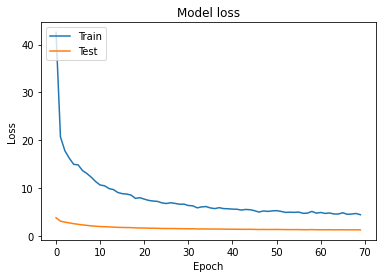

Kappa Score: 0.9690772488848252

--------Fold 2--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.8998920917510986 sec
Time to train the word2vec model: 48.410395860672 mins
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
10381

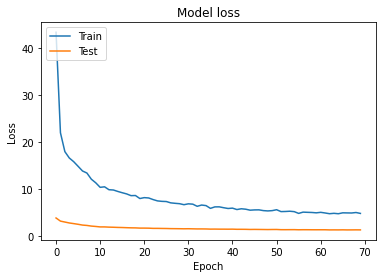

Kappa Score: 0.9723570173189542

--------Fold 3--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.8663942813873291 sec
Time to train the word2vec model: 47.800869941711426 mins
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_5 (Bidirection (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
10

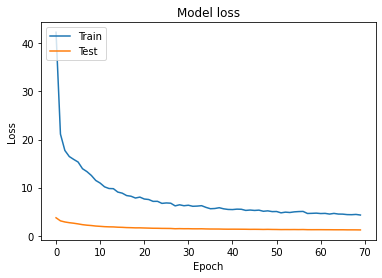

Kappa Score: 0.9681606637795384

--------Fold 4--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.8679554462432861 sec
Time to train the word2vec model: 47.314122915267944 mins
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_7 (Bidirection (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 200)               560800    
_________________________________________________________________
dropout_4 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
10

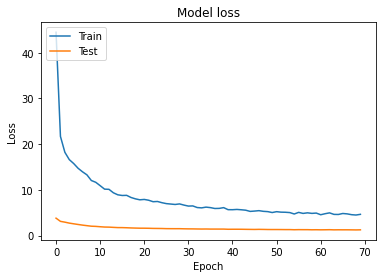

Kappa Score: 0.9725130742146156

--------Fold 5--------

Converting sentences to word2vec model

 4 cores using
Time to build vocab using word2vec: 0.8937320709228516 sec
Time to train the word2vec model: 48.75269365310669 mins
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_9 (Bidirection (None, 1, 600)            1682400   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 200)               560800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 201       
Total params: 2,243,401
Trainable params: 2,243,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
103

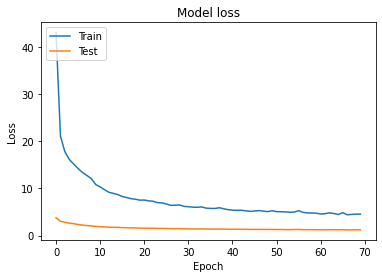

Kappa Score: 0.9569597144906096
Average kappa score value is : 0.9678135437377084


In [0]:
# Whole Dataset Word2vec
X= data
y = data['domain1_score']
import time
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')
set_count = 1
all_sets_score = []
# Hyperparameters for word2vec
num_features = 400
min_word_count = 40
num_workers = 4
context = 10
downsampling = 1e-3
epochs = 30

# Hyperpaprameters for LSTM
Hidden_dim1=300
Hidden_dim2=100
return_sequences = True
dropout=0.5
recurrent_dropout=0.4
input_size=400
activation='relu'
bidirectional = True
batch_size = 64
epoch = 70
#####
####
import tensorflow as tf
tf.keras.backend.clear_session()
cv = KFold(n_splits=5, shuffle=True)
#X, y = prepare_data(dataset_path=dataset_path)
cv_data = cv.split(X)
results = []
prediction_list = []
fold_count =1
# hyperparameters for word2vec
most_common_words= []
print(X.shape)
print(y.shape)
for traincv, testcv in cv_data:
    print("\n--------Fold {}--------\n".format(fold_count))
    # get the train and test from the dataset.
    X_train, X_test, y_train, y_test = X.iloc[traincv], X.iloc[testcv], y.iloc[traincv], y.iloc[testcv]
    train_essays = X_train['essay']
    #print("y_train",y_train)
    test_essays = X_test['essay']
    #y_train = torch.tensor(y_train,dtype=torch.long)
    train_sentences = []
    # print("train_essay ",train_essays.shape)
    #print(X_train.shape,y_train.shape)
    for essay in train_essays:
        # get all the sentences from the essay
        train_sentences.append(essay_to_wordlist(essay, remove_stopwords = True))

    # word2vec embedding
    print("Converting sentences to word2vec model")
    model,_ = build_word2vec(train_sentences, num_workers, num_features, min_word_count, context,
                  downsampling)
    top10 = collections.defaultdict(int)

    # print("train_sentencesshap",len(train_sentences))
    trainDataVecs = np.array(getAvgFeatureVecs(train_sentences, model, num_features))
    test_sentences = []
    for essay_v in test_essays:
        test_sentences.append(essay_to_wordlist(essay_v, remove_stopwords=True))
    testDataVecs = np.array(getAvgFeatureVecs(test_sentences, model, num_features))
    trainDataVectors = np.reshape(trainDataVecs, (trainDataVecs.shape[0], 1, trainDataVecs.shape[1]))
    testDataVectors = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    lstm_model = get_model_lstm(Hidden_dim1=Hidden_dim1, Hidden_dim2=Hidden_dim2, return_sequences=return_sequences,
                            dropout=dropout, recurrent_dropout=recurrent_dropout, input_size=input_size,
                            activation=activation, bidirectional=bidirectional)
    # print(trainDataVectors.shape)
    # print(y_train.shape)
    history = lstm_model.fit(trainDataVectors, y_train, batch_size=batch_size, epochs=epoch)
    plot_accuracy_curve(history)
    y_pred = lstm_model.predict(testDataVectors)
    y_pred = np.around(y_pred)
    np.nan_to_num(y_pred)
    result = cohen_kappa_score(y_test.values, y_pred, weights='quadratic')
    print("Kappa Score: {}".format(result))
    results.append(result)
    fold_count += 1

print("Average kappa score value is : {}".format(np.mean(np.asarray(results))))
